In [380]:
import boto3
import json
from datasets import Dataset, load_dataset
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Use retina mode
%config InlineBackend.figure_format = 'retina'

from sal.utils.math import (
    find_majority_answer, extract_completion_answers,
    memoized_canonical_form, find_answer_with_largest_sum,
    strip_string
)

def download_and_load_json(full_path, local_path):
    file_dir = full_path
    bucket_name, key = file_dir.replace('s3://', '').split('/', 1)
    s3 = boto3.client('s3')
    # Remove local_path if it exists
    try:
        os.remove(local_path)
    except OSError:
        pass
    try:
        s3.download_file(bucket_name, key, local_path)
    except Exception as e:
        print(f"Error downloading file: {e}")
        print(key)

    # print(f"File downloaded to {local_path}")
    model_responses = []
    with open(local_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        return data


In [288]:
dataset_name = "jeggers/gpqa_formatted"
dataset_split = "train"
dataset = load_dataset(dataset_name, 'diamond', split=dataset_split)

In [5]:
# QID = 20
# QID = 79
QID = 2
GT = (dataset[QID]['answer'])
GT = options = chr(65 + dataset[QID]['answer'])

In [ ]:
all_answers = []
qid = QID
folder_name = 'dpsk_new_sample_long_long_with_final_answer_gpqa_mc'
# folder_name = 'dpsk_new_sample_long_long_with_final_answer_gpqa'
all_seeds = [1, 2, 3, 4, 5, 6, 7]
save_name = 'gpqa_diamond_mc'
for seed in all_seeds:
    # file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/dpsk_new_det_with_final_answer/seed_{seed}/answers_{qid}.json'
    file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/{folder_name}/seed_{seed}/answers_{qid}.json'
    F = download_and_load_json(file_dir, f'/tmp/answers_{save_name}.json')
    all_answers.append(F)

all_answers = np.array(all_answers)
all_answers = all_answers.transpose(1, 0, 2).reshape(-1, 7 * 16)

row = all_answers[107]
extracted_answers= [
                memoized_canonical_form(a, timeout_seconds=10) for a in extract_completion_answers(
                {'completions': row},
    )['preds']]

# Actually result

In [381]:
import sys
sys.path.append('/root/tts_and_entropy')
from early_stopping_utils import choose_early_stop_point, exponential_moving_variance


def fine_line_with_max_token(reason_length, max_token=1024):
    """
    Find the line with the maximum token length that is less than or equal to max_token.
    """
    for i, length in enumerate(reason_length):
        if length > max_token:
            return i - 1
    return len(reason_length) - 1


def load_log(QID, acc_dir, entropy_dir, entropy_pattern, include_ans=False):
    tmp_dir = acc_dir
    entropy_base_dir = entropy_dir

    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )

    ENTROPY = np.load(
        os.path.join(entropy_base_dir, entropy_pattern.format(QID))
    )

    if include_ans:
        ANS = np.load(
            os.path.join(tmp_dir, f'all_extracted_answers_{QID}.npy')
        )
        ua = []
        for _A in ANS:
            ua.append(len(np.unique(_A)))
        return ACC, ENTROPY, np.array(ua), ANS
    
    return ACC, ENTROPY

In [382]:
from transformers import AutoTokenizer
model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_with_sample_long_gpqa_mc.json"

MAX_RANGE = 198

model_solutions = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions.append(json.loads(line.strip()))
model_solutions = model_solutions[:MAX_RANGE]
reason_lengths = []
reason_number_of_lines = []

model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

for row in model_solutions:
    model_response = (row['response'])
    model_response = model_response.split('</think>')[0]
    # reasoning_line = model_response.split("<think>")[1].split('\n')[1::2]
    reasoning_line = model_response.split("<think>")[1].split('\n\n')
    # Extract reasoning length of each line
    reasoning_length = np.array([
        len(tokenizer(line)['input_ids']) for line in reasoning_line
    ])
    reasoning_length = np.cumsum(reasoning_length)
    reason_lengths.append(reasoning_length)

In [383]:
all_accs, all_entropy, all_unique_answers, all_extracted_answers = [], [], [], []
all_entropy_with_final_ans = []
all_entropy_with_final_ans_dpsk_small = []
acc_dir = '/root/tts_and_entropy/outputs/cached_resultsgpqa_mc_dpsk_new'

entropy_template = 'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_gpqa_mc.npy'
entropy_template_2 = 'entropy_{}_new_dpsk_new_with_sample_ngram_gpqa_mc.npy'
entropy_template_dpsk_small = 'entropy_{}_new_dpsk_new_with_sample_ngram_gpqa_mc_eatEvaluedBydpsk_small.npy'
entropy_template_dpsk_small_2 = 'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_gpqa_mc_eatEvaluedBydpsk_small.npy'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

for qid in tqdm(range(MAX_RANGE)):
    acc, entropy = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template,
        include_ans=False
    )

    _, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_2,
        include_ans=False
    )
    all_accs.append(acc)
    all_entropy.append((entropy[:, 1], entropy_2[:, 1]))
    # all_entropy.append((entropy[:, 1] + entropy_2[:, 1]) / 2)
    # all_unique_answers.append(unique_answers)
    # all_extracted_answers.append(extracted_answers)

    acc, entropy_1 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_dpsk_small,
        include_ans=False
    )

    acc, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_dpsk_small_2,
        include_ans=False
    )

    all_entropy_with_final_ans_dpsk_small.append(
        (entropy_1[:, 1], entropy_2[:, 1])
    )

 40%|█████████████████████████████████████████████████████████▎                                                                                    | 80/198 [00:00<00:00, 795.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 836.08it/s]


In [384]:
VALID_IDX = []
for qid in range(MAX_RANGE):
    token_cost = reason_lengths[qid]
    acc = all_accs[qid]
    if acc[-1] > 0.8:
        VALID_IDX.append(qid)
# VALID_IDX = np.arange(MAX_RANGE)

In [358]:
len(VALID_IDX)

81

In [385]:
max_token_budget = [
    250 * i for i in range(1, 41)
]

accs = []
total_tokens = []
token_usage = []

for budget in tqdm(max_token_budget):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        if qid not in VALID_IDX:
            continue
        token_cost = reason_lengths[qid]
        acc = all_accs[qid]
        line_number = fine_line_with_max_token(token_cost, max_token=budget)
        _total_tokens.append(token_cost[line_number])
        _accs.append(acc[line_number])
    accs.append(_accs)
    total_tokens.append(np.sum(_total_tokens))
    token_usage.append(_total_tokens)

accs = np.array(accs)
total_tokens = np.array(total_tokens)
total_usage = np.array(token_usage)

  0%|                                                                                                                                                         | 0/40 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 311.79it/s]


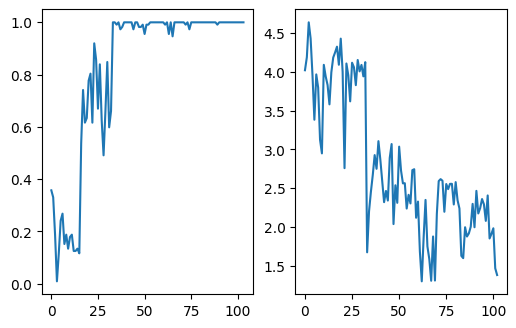

In [815]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.7))
I = 35
ax[0].plot(all_accs[VALID_IDX[I]])
ax[1].plot(all_entropy[VALID_IDX[I]][0][:])

In [386]:
thresholds = np.array([1.5 ** (-i) for i in range(0, 80)])
# thresholds = np.array([1 * 10 ** (-i) for i in range(0, 20)] + [5 * 10 ** (-i) for i in range(1, 21)])
thresholds = np.sort(thresholds)
accs_entropy_and_token = {}
total_tokens_entropy_and_token = {}
tokens_entropy_and_token = {}
EIDX = [1]
models = ['dpsk_new', 'dpsk_small']
timescales = [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]

for timescale in timescales:
    for eidx in EIDX:
        for model in models:
            accs_entropy_and_token[(timescale, eidx, model)] = []
            total_tokens_entropy_and_token[(timescale, eidx, model)] = []
            tokens_entropy_and_token[(timescale, eidx, model)] = []
            for t in tqdm(thresholds):
                _accs = []
                _total_tokens = []
                for qid in range(MAX_RANGE):
                    if qid not in VALID_IDX:
                        continue
                    token_cost = reason_lengths[qid]
                    if model == 'dpsk_new':
                        acc, entropy_1, entropy_2  = all_accs[qid], all_entropy[qid][0][:], all_entropy[qid][1][:]
                    elif model == 'dpsk_small':
                        acc, entropy_1, entropy_2  = all_accs[qid], all_entropy_with_final_ans_dpsk_small[qid][0][:], all_entropy_with_final_ans_dpsk_small[qid][1][:]
                    exit_idx = fine_line_with_max_token(token_cost, max_token=10000)
                    exit_idx_entropy_1 = choose_early_stop_point(
                        # (entropy_1 + entropy_2) / 2,
                        entropy_2,
                        timescale, t, 80, min_value_threshold=None, normalize=False) 
                    exit_idx_entropy = exit_idx_entropy_1
                    if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                        exit_idx_entropy = exit_idx
                    _total_tokens.append(token_cost[exit_idx_entropy])
                    _accs.append(acc[exit_idx_entropy])
                accs_entropy_and_token[(timescale, eidx, model)].append(_accs)
                total_tokens_entropy_and_token[(timescale, eidx, model)].append(np.sum(_total_tokens))
                tokens_entropy_and_token[(timescale, eidx, model)].append(_total_tokens)

            accs_entropy_and_token[(timescale, eidx, model)] = np.array(accs_entropy_and_token[(timescale, eidx, model)]).reshape(len(thresholds), len(VALID_IDX))
            total_tokens_entropy_and_token[(timescale, eidx, model)] = np.array(total_tokens_entropy_and_token[(timescale, eidx, model)]).reshape(len(thresholds))
            tokens_entropy_and_token[(timescale, eidx, model)] = np.array(tokens_entropy_and_token[(timescale, eidx, model)]).reshape(len(thresholds), len(VALID_IDX))

  0%|                                                                                                                                                         | 0/80 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 20.25it/s]


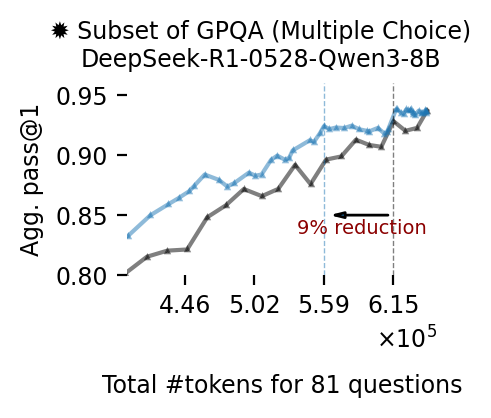

In [387]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(2.0, 2.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3,4,5])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

TT = total_tokens_entropy_and_token[(0.2, 1, 'dpsk_new')]
ACC = accs_entropy_and_token[(0.2, 1, 'dpsk_new')]

ax.plot(total_tokens, accs.mean(1), color='black',
    **line_config)

ax.plot(TT, ACC.mean(1), c=my_colors[0],
        linestyle='-',
        **line_config)

class ScalarFormatterForceFormat(mticker.ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.2f"  # Give format here

formatter = ScalarFormatterForceFormat(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)

ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel(f'Total #tokens for {len(VALID_IDX)} questions', fontsize=FONT_SIZE, labelpad=20.0)
ax.set_title(u"✹ Subset of " + 'GPQA (Multiple Choice)\nDeepSeek-R1-0528-Qwen3-8B', fontsize=FONT_SIZE, x=0.43)
ax.set_box_aspect(0.618)
ax.set_xlim(4e5, 6.5e5)
ax.set_ylim(.8, .96)

for a in ax.spines.values():
    a.set_visible(False)

threshold = 0.92

blue_line_idx = TT[::-1][np.argmax(ACC.mean(1)[::-1] > threshold)]
ax.axvline(blue_line_idx, color=my_colors[0], linestyle='--', linewidth=.5, alpha=0.5)

black_line_idx = total_tokens[np.argmax(accs.mean(1) > threshold)]
ax.axvline(black_line_idx, color='black', linestyle='--', linewidth=.5, alpha=0.5)

y_target = 0.85

import matplotlib.patches as mpatches
arr = mpatches.FancyArrowPatch((black_line_idx, y_target), (blue_line_idx, y_target),
                               arrowstyle='-|>,head_width=.1',
                            # arrowstyle='simple',
                               mutation_scale=9)
ax.add_patch(arr)
ax.annotate("9% reduction",
    (.5, -4.0), xycoords=arr, ha='center', va='bottom',
    fontsize=7, color='darkred')

GAP_SIZE = black_line_idx - blue_line_idx
ax.set_xticks([blue_line_idx - 2 * GAP_SIZE, blue_line_idx - GAP_SIZE, blue_line_idx, black_line_idx])

fig.savefig('/root/figures/gpqa_dpsk_new_mc.pdf', bbox_inches='tight')

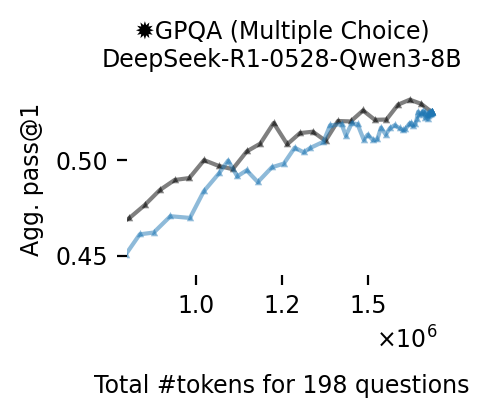

In [ ]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(2.0, 2.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3,4,5])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

TT = total_tokens_entropy_and_token[(0.075, 1, 'dpsk_new')]
ACC = accs_entropy_and_token[(0.075, 1, 'dpsk_new')]

ax.plot(total_tokens, accs.mean(1), color='black',
    **line_config)

ax.plot(TT, ACC.mean(1), c=my_colors[0],
        linestyle='-',
        **line_config)

class ScalarFormatterForceFormat(mticker.ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

formatter = ScalarFormatterForceFormat(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)

ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel('Total #tokens for 198 questions', fontsize=FONT_SIZE, labelpad=20.0)
ax.set_title(u"✹" + 'GPQA (Multiple Choice)\nDeepSeek-R1-0528-Qwen3-8B', fontsize=FONT_SIZE)
ax.set_box_aspect(0.618)
ax.set_xlim(.8e6, 1.7e6)
ax.set_ylim(.44, .54)

for a in ax.spines.values():
    a.set_visible(False)

fig.savefig('/root/tts_and_entropy/outputs/gpqa_dpsk_new_mc.pdf', bbox_inches='tight')

In [ ]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(2.0, 2.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3,4,5])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

TT = total_tokens_entropy_and_token[(0.075, 1, 'dpsk_new')]
ACC = accs_entropy_and_token[(0.075, 1, 'dpsk_new')]

ax.plot(total_tokens, accs.mean(1), color='black',
    **line_config)

ax.plot(TT, ACC.mean(1), c=my_colors[0],
        linestyle='-',
        **line_config)

class ScalarFormatterForceFormat(mticker.ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.1f"  # Give format here

formatter = ScalarFormatterForceFormat(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)

ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel('Total #tokens for 198 questions', fontsize=FONT_SIZE, labelpad=20.0)
ax.set_title(u"✹" + 'GPQA (Multiple Choice)\nDeepSeek-R1-0528-Qwen3-8B', fontsize=FONT_SIZE)
ax.set_box_aspect(0.618)
ax.set_xlim(.8e6, 1.7e6)
ax.set_ylim(.44, .54)

for a in ax.spines.values():
    a.set_visible(False)

fig.savefig('/root/tts_and_entropy/outputs/gpqa_dpsk_new_mc.pdf', bbox_inches='tight')

1.0


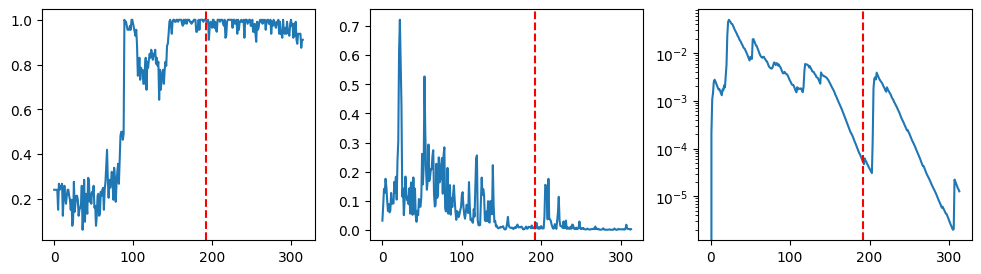

In [632]:
qid = 51
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

timescale = 0.1
# t = 2 ** -10
t = thresholds[-10]
token_cost = reason_lengths[qid]
E = all_entropy[qid][1][:]
exit_idx = fine_line_with_max_token(token_cost, max_token=10000)
exit_idx_entropy = choose_early_stop_point(E, timescale, t, 80, min_value_threshold=None, normalize=False) 
print(all_accs[qid][exit_idx_entropy])
ax[0].plot(all_accs[qid])
ax[1].plot(E)
ax[2].plot(exponential_moving_variance(E, timescale))
ax[2].set_yscale('log')


for a in ax:
    a.axvline(exit_idx_entropy, color='red', linestyle='--', label='Max Token')

In [159]:
thresholds = np.array([1.5 ** (-i) for i in range(0, 80)])
EIDX = [2]
timescales = [0.05, 0.075, 0.1, 0.15, 0.2, 0.3]

for timescale in timescales:
    for eidx in EIDX:
        accs_entropy_and_token[(timescale, eidx)] = []
        total_tokens_entropy_and_token[(timescale, eidx)] = []
        tokens_entropy_and_token[(timescale, eidx)] = []
        for t in tqdm(thresholds):
            _accs = []
            _total_tokens = []
            for qid in range(MAX_RANGE):
                token_cost = reason_lengths[qid]

                # acc, entropy = all_accs[qid], all_entropy_with_final_ans_dpsk_small[qid][:, 1]
                acc, entropy = all_accs[qid], all_entropy_with_final_ans_dpsk_small[qid][:]
                exit_idx = fine_line_with_max_token(token_cost, max_token=20000)

                exit_idx_entropy = choose_early_stop_point(entropy, timescale, t, 40, min_value_threshold=None, normalize=False) 
                
                if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                    exit_idx_entropy = exit_idx
                _total_tokens.append(token_cost[exit_idx_entropy])
                _accs.append(acc[exit_idx_entropy])
            accs_entropy_and_token[(timescale, eidx)].append(_accs)
            total_tokens_entropy_and_token[(timescale, eidx)].append(np.sum(_total_tokens))
            tokens_entropy_and_token[(timescale, eidx)].append(_total_tokens)

        accs_entropy_and_token[(timescale, eidx)] = np.array(accs_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), MAX_RANGE)
        total_tokens_entropy_and_token[(timescale, eidx)] = np.array(total_tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds))
        tokens_entropy_and_token[(timescale, eidx)] = np.array(tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), MAX_RANGE)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:03<00:00, 26.34it/s]


# Open ended version

In [388]:
import nflx_genai as genai
genai.project_id = "metafwlo"
client = genai.Client()


def view_job_results(job_id):
    completed_batch = client.batches.retrieve(
        batch_id=job_id
    )
    return completed_batch

def extract_results(job_id, num_rollouts=128):
    completed_batch = client.batches.retrieve(
        batch_id=job_id
    )
    results = client.files.content(
        file_id=completed_batch.output_file_id
    )
    accs = []
    buffer = []
    for i, line in enumerate(results.read().decode("utf-8").split("\n")[:-1]):
        line = json.loads(line)
        output = line['response']['body']['choices'][0]['message']['content']
        if '<answer>' not in output:
            continue
        output = output.split('<answer>')[1].split('</answer>')[0]
        if output == '0':
            buffer.append(0)
        elif output == '1':
            buffer.append(1)
        if i % num_rollouts == 0 and i > 0:
            accs.append(np.mean(buffer))
            buffer = []
    return np.array(accs)

In [833]:
import ast
job_id_dir = '/root/tts_and_entropy/notebooks/temp.txt'
with open(job_id_dir, 'r') as f:
    job_id = f.read().strip()
    job_id_big = ast.literal_eval(job_id)

In [ ]:
# import pickle
# with open('/root/tts_and_entropy/outputs/accs_gpqa_128.pkl', 'wb') as f:
#     pickle.dump(all_accs_gpqa, f)


In [389]:
from transformers import AutoTokenizer
model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_with_sample_long_gpqa.json"

MAX_RANGE = len(dataset)

model_solutions = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions.append(json.loads(line.strip()))
model_solutions = model_solutions[:MAX_RANGE]
reason_lengths = []
reason_number_of_lines = []

model_name = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

for row in model_solutions:
    model_response = (row['response'])
    model_response = model_response.split('</think>')[0]
    # reasoning_line = model_response.split("<think>")[1].split('\n')[1::2]
    reasoning_line = model_response.split("<think>")[1].split('\n\n')
    # Extract reasoning length of each line
    reasoning_length = np.array([
        len(tokenizer(line)['input_ids']) for line in reasoning_line
    ])
    reasoning_length = np.cumsum(reasoning_length)
    reason_lengths.append(reasoning_length)

In [390]:
all_entropy, all_unique_answers, all_extracted_answers = [], [], []
all_entropy_with_final_ans = []
all_entropy_with_final_ans_dpsk_small = []
acc_dir = '/root/tts_and_entropy/outputs/cached_results'

entropy_template = 'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_gpqa.npy'
entropy_template_2 = 'entropy_{}_new_dpsk_new_with_sample_ngram_gpqa.npy'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'
MAX_RANGE = len(dataset)
for qid in tqdm(range(MAX_RANGE)):
    _, entropy = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template,
        include_ans=False
    )

    _, entropy_2 = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_template_2,
        include_ans=False
    )
    all_entropy_with_final_ans.append((entropy, entropy_2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 198/198 [00:00<00:00, 1607.30it/s]


In [391]:
# Save accs_gpqa to a pickle file
import pickle
# with open('/root/tts_and_entropy/outputs/accs_gpqa.pkl', 'rb') as f:
with open('/root/tts_and_entropy/outputs/accs_gpqa_128.pkl', 'rb') as f:
    accs_gpqa = pickle.load(f)

VALID_IDX = []
for qid in range(MAX_RANGE):
    token_cost = reason_lengths[qid]
    acc = accs_gpqa[qid]
    if acc[-1] > 0.8:
        VALID_IDX.append(qid)
# VALID_IDX = np.arange(MAX_RANGE)

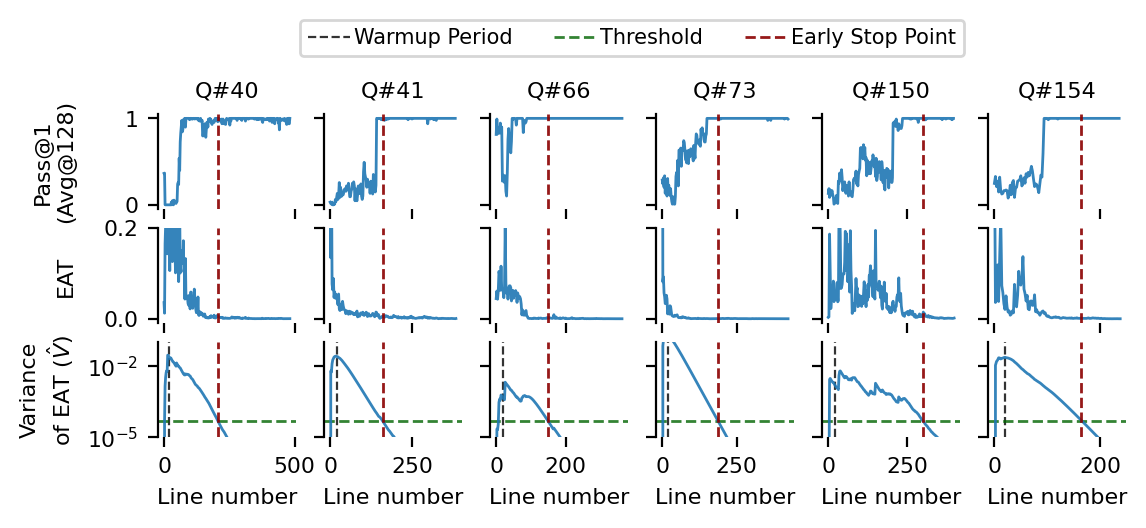

In [165]:
QIDs = [31, 29, 10, 14, 4, 5]
QIDs.sort()
line_config = {
    'linewidth': 1.0, 'alpha': 0.9,
}
LF_SIZE = 8
fig, ax = plt.subplots(
    3, len(QIDs),
    figsize=(6.25, 2.1),
    sharex='col', sharey='row'
)

T = 5e-5
TS = 0.1

for a in ax[2]:
    a.axvline(2 / TS, color='black', linestyle='--', linewidth=0.8, alpha=0.8, label='Warmup Period')
    a.axhline(T, linestyle='--', linewidth=1.0, alpha=0.8, color='darkgreen', label='Threshold')
    a.set_xlabel('Line number', fontsize=LF_SIZE)

for i, QID in enumerate(QIDs):
    # E = ent[:, 1]
    acc = accs_gpqa[VALID_IDX[QID]]
    E = all_entropy_with_final_ans[VALID_IDX[QID]][1][::2, 1]
    X = np.arange(len(acc)) * 2
    ax[0, i].plot(X, acc, **line_config)
    X = np.arange(len(E)) * 2
    ax[1, i].plot(X, E, **line_config)
    VAR = exponential_moving_variance(E, TS, ema_0=0.0)
    X = np.arange(len(VAR)) * 2
    ax[2, i].plot(X, VAR, **line_config)
    ax[0, i].set_title(f'Q#{VALID_IDX[QID]}', fontsize=LF_SIZE)
    stop_point = choose_early_stop_point(
        E, TS, T, min_distance=2 / TS, ema_0=0.0
    )
    ax[0, i].axvline(stop_point * 2, color='darkred', linestyle='--', linewidth=1.0, alpha=0.9)
    ax[1, i].axvline(stop_point * 2, color='darkred', linestyle='--', linewidth=1.0, alpha=0.9)
    ax[2, i].axvline(stop_point * 2, color='darkred', linestyle='--', linewidth=1.0, alpha=0.9, label='Early Stop Point')

ax[1, 0].set_ylim(-0.01, .2)
ax[2, 0].set_yscale('log')
ax[2, 0].set_ylim(1e-5, 1e-1)


ax[0,0].set_ylabel('Pass@1\n(Avg@128)', fontsize=LF_SIZE)
ax[1,0].set_ylabel('EAT', fontsize=LF_SIZE)
ax[2,0].set_ylabel("Variance\nof EAT " + r"$(\hat{V})$", fontsize=LF_SIZE)

fig.align_ylabels(ax[:, 0])

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=LF_SIZE - 0.1, axis='both')

ax[2, 0].legend(
    loc='upper right', fontsize=LF_SIZE - 0.5, ncol=3,
    frameon=True, handlelength=2.0, handletextpad=0.2,
    bbox_to_anchor=(5.9, 4.5)
)
fig.savefig('/root/figures/early_stop_illustration_gpqa_open_ended.pdf', bbox_inches='tight')

In [166]:
dataset_name = "Idavidrein/gpqa"
dataset_split = "train"
dataset = load_dataset(dataset_name, 'gpqa_diamond', split=dataset_split)
print(dataset[qid]['Pre-Revision Question'])

We have a solution containing Co(II) ions and thiocyanate, where the total cobalt concentration is c(Co) = 10^-2 M and the [SCN-] concentration is 0.1 M. The stability constants of the copper(II) thiocyanato complexes are β1=9, β2=40, β3=63 and β4=16. What will be the percentage of the blue dithiocyanato cobalt(II) complexes and the amongst all cobalt containing species in the solution? 


In [ ]:
file_dir = '/root/batch_job_log/job_dict_gpqa_1.json'
# Load file_dir into dictionary using json
with open(file_dir, 'r') as f:
    job_dict = json.load(f)

In [392]:
max_token_budget = [
    250 * i for i in range(1, 41)
]
# VALID_IDX = np.arange(MAX_RANGE)

accs = []
total_tokens = []
token_usage = []

for budget in tqdm(max_token_budget):
    _accs = []
    _total_tokens = []
    for qid in VALID_IDX:
        token_cost = reason_lengths[qid][1::2]
        acc = accs_gpqa[qid]
        line_number = fine_line_with_max_token(token_cost, max_token=budget)
        _total_tokens.append(token_cost[line_number])
        _accs.append(acc[line_number])
    accs.append(_accs)
    total_tokens.append(np.sum(_total_tokens))
    token_usage.append(_total_tokens)

accs = np.array(accs)
total_tokens = np.array(total_tokens)
total_usage = np.array(token_usage)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 1059.37it/s]


In [393]:
thresholds = np.array([1.5 ** (-i) for i in range(0, 80)])
# thresholds = np.array([1 * 10 ** (-i) for i in range(0, 20)] + [5 * 10 ** (-i) for i in range(1, 21)])
thresholds = np.sort(thresholds)
accs_entropy_and_token = {}
total_tokens_entropy_and_token = {}
tokens_entropy_and_token = {}
EIDX = [1]
timescales = [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25]

for timescale in timescales:
    for eidx in EIDX:
        accs_entropy_and_token[(timescale, eidx)] = []
        total_tokens_entropy_and_token[(timescale, eidx)] = []
        tokens_entropy_and_token[(timescale, eidx)] = []
        for t in tqdm(thresholds):
            _accs = []
            _total_tokens = []
            for qid in VALID_IDX:
                token_cost = reason_lengths[qid][1::2]

                acc, entropy_1, entropy_2  = accs_gpqa[qid], all_entropy_with_final_ans[qid][0][1::2, 1], all_entropy_with_final_ans[qid][1][1::2, 1]
                exit_idx = fine_line_with_max_token(token_cost, max_token=10000)
                # E = (entropy_1 + entropy_2) / 2
                E = entropy_1
                # exit_idx_entropy_1 = choose_early_stop_point(entropy_1, timescale, t, 80, min_value_threshold=None, normalize=False) 
                # exit_idx_entropy = exit_idx_entropy_1
                # exit_idx_entropy_2 = choose_early_stop_point(entropy_2, timescale, t, 80, min_value_threshold=None, normalize=False) 
                # Pick the one that exits earlier
                exit_idx_entropy = choose_early_stop_point(E, timescale, t, 80, min_value_threshold=None, normalize=False, ema_0=0.0)
                # if exit_idx_entropy_1 == -1:
                #     exit_idx_entropy_1 = exit_idx
                # if exit_idx_entropy_2 == -1:
                #     exit_idx_entropy_2 = exit_idx
                # exit_idx_entropy = exit_idx_entropy_1 if exit_idx_entropy_1 < exit_idx_entropy_2 else exit_idx_entropy_2
                if exit_idx_entropy == -1 or exit_idx_entropy > exit_idx:
                    exit_idx_entropy = exit_idx
                _total_tokens.append(token_cost[exit_idx_entropy])
                _accs.append(acc[exit_idx_entropy])
            accs_entropy_and_token[(timescale, eidx)].append(_accs)
            total_tokens_entropy_and_token[(timescale, eidx)].append(np.sum(_total_tokens))
            tokens_entropy_and_token[(timescale, eidx)].append(_total_tokens)

        accs_entropy_and_token[(timescale, eidx)] = np.array(accs_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), len(VALID_IDX))
        total_tokens_entropy_and_token[(timescale, eidx)] = np.array(total_tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds))
        tokens_entropy_and_token[(timescale, eidx)] = np.array(tokens_entropy_and_token[(timescale, eidx)]).reshape(len(thresholds), len(VALID_IDX))

  0%|                                                                                                                                                         | 0/80 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 68.53it/s]


In [394]:
results_opt = []
target_acc = [0.19, 0.29, 0.39, 0.49, 0.59, 0.69, 0.79, 0.89, 0.99]
accs_posthoc_acc = []
total_tokens_posthoc_acc = []
exit_idxes = []
for t in tqdm(target_acc):
    _accs = []
    _total_tokens = []
    for qid in range(MAX_RANGE):
        if qid not in VALID_IDX:
            continue
        token_cost = reason_lengths[qid][::2]
        acc = accs_gpqa[qid]
        exit_idx = np.argmax([acc > t])
        if acc.max() < t:
            exit_idx = -1
        exit_idxes.append(exit_idx)
        _total_tokens.append(token_cost[exit_idx])
        _accs.append(acc[exit_idx])
    accs_posthoc_acc.append(_accs)
    total_tokens_posthoc_acc.append(np.sum(_total_tokens))

accs_posthoc_acc = np.array(accs_posthoc_acc)
total_tokens_posthoc_acc = np.array(total_tokens_posthoc_acc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 1332.84it/s]


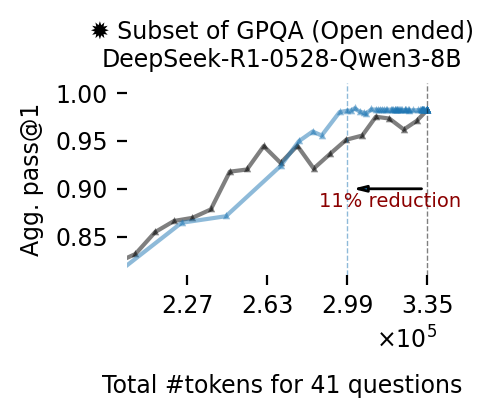

In [395]:
import matplotlib.ticker as mticker
fig, ax = plt.subplots(figsize=(2.0, 2.0))
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3,4,5])

FONT_SIZE = 8.5

line_config = {
    'marker': '^',
    'markersize': 1, 'linewidth': 1.5,
    'alpha': 0.5
}

TT = total_tokens_entropy_and_token[(0.2, 1)]
ACC = accs_entropy_and_token[(0.2, 1)]

ax.plot(total_tokens, accs.mean(1), color='black',
    **line_config)

ax.plot(TT, ACC.mean(1), c=my_colors[0],
        linestyle='-',
        **line_config)

class ScalarFormatterForceFormat(mticker.ScalarFormatter):
    def _set_format(self):  # Override function that finds format to use.
        self.format = "%1.2f"  # Give format here

formatter = ScalarFormatterForceFormat(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)

ax.get_xaxis().get_offset_text().set_fontsize(FONT_SIZE)
ax.tick_params(axis='both', labelsize=FONT_SIZE)
ax.set_ylabel('Agg. pass@1', fontsize=FONT_SIZE)
ax.set_xlabel(f'Total #tokens for {len(VALID_IDX)} questions', fontsize=FONT_SIZE, labelpad=20.0)
ax.set_title(u"✹ Subset of " + 'GPQA (Open ended)\nDeepSeek-R1-0528-Qwen3-8B', fontsize=FONT_SIZE)
ax.set_box_aspect(0.618)
ax.set_xlim(2e5, 3.4e5)
ax.set_ylim(.81, 1.01)

threshold = 0.98

blue_line_idx = TT[::-1][np.argmax(ACC.mean(1)[::-1] > threshold)]
ax.axvline(blue_line_idx, color=my_colors[0], linestyle='--', linewidth=.5, alpha=0.5)

black_line_idx = total_tokens[np.argmax(accs.mean(1) > threshold)]
ax.axvline(black_line_idx, color='black', linestyle='--', linewidth=.5, alpha=0.5)

for a in ax.spines.values():
    a.set_visible(False)


y_target = 0.9

import matplotlib.patches as mpatches
arr = mpatches.FancyArrowPatch((black_line_idx, y_target), (blue_line_idx, y_target),
                               arrowstyle='-|>,head_width=.1',
                            # arrowstyle='simple',
                               mutation_scale=9)
ax.add_patch(arr)
ax.annotate("11% reduction",
    (.5, -4.0), xycoords=arr, ha='center', va='bottom',
    fontsize=7, color='darkred')

# ax.set_xticks([2.2e5, 2.6e5, blue_line_idx, black_line_idx])
GAP_SIZE = black_line_idx - blue_line_idx
ax.set_xticks([blue_line_idx - 2 * GAP_SIZE, blue_line_idx - GAP_SIZE, blue_line_idx, black_line_idx])

fig.savefig('/root/figures/gpqa_dpsk_new_open_ended.pdf', bbox_inches='tight')

In [280]:
(black_line_idx - blue_line_idx) / black_line_idx

np.float64(0.10776079262711283)